In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

from collections import Counter

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(mbs_model)
reload(read_activations)
reload(utils);
%matplotlib inline
#%matplotlib notebook

# Load data

In [2]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, tokenizer = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False, random_state0=42, random_state1=420)

In [4]:
dataset['mbs_seq'].head()

PIN
568483     10990 23 725 10990 10990 10990 10993 23 85311 ...
923748     66653 65070 66515 10962 105 56807 10990 23 109...
2035328    66536 74995 66512 66551 66608 66716 66560 7392...
2239386    10991 23 73928 66560 66515 66551 66536 2517 10...
2244533    10990 23 23 10990 73928 66500 66560 66551 23 1...
Name: mbs_seq, dtype: object

Basic counter

In [24]:
ll = utils.flatten([x.split(' ') for x in dataset['mbs_seq'].values.ravel()])
dd = pd.DataFrame.from_dict(Counter(ll), orient='index').rename(columns={0: 'Counts'})

In [26]:
dd.nlargest(10, columns='Counts')

,Counts
23,320049
10990,257995
10991,227207
73928,87099
74995,71766
66512,67740
36,50606
65070,46726
116,29110
66551,28993


In [27]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

In [28]:
# Build an inverse word map
word_map = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
word_map[0] = 0

In [29]:
item_map = pd.read_csv('../../mbspbs10pc/data/item_map.tsv', sep='\t', header=0, index_col=0,
                      usecols=['ITEM', 'Mapped_Item_Desc', 'CATEGORY_DESC'])
item_map.loc[0, :] = ['', '']
item_map.head()

,Mapped_Item_Desc,CATEGORY_DESC
ITEM,,
1,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
2,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
3,Professional attendance at consulting rooms (n...,PROFESSIONAL ATTENDANCES
4,Consultation at a place other than consulting ...,PROFESSIONAL ATTENDANCES
5,Professional attendance at consulting rooms of...,PROFESSIONAL ATTENDANCES


# Load model

In [31]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/single_run/auc_879/output_weights.h5')

# Visualize the attention weights

In [32]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tsg_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [33]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # 50 x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x 50
w = We[D[0][0]].dot(W).squeeze()  # 6341 x 445
print(w.shape)

(4698, 250)


In [34]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

(4698, 250)

In [35]:
c = w * avg_omega
print(c.shape)

(4698, 250)


In [36]:
neg = np.where(D[1] == 0)[0]
pos = np.where(D[1] == 1)[0]

Group class attention:

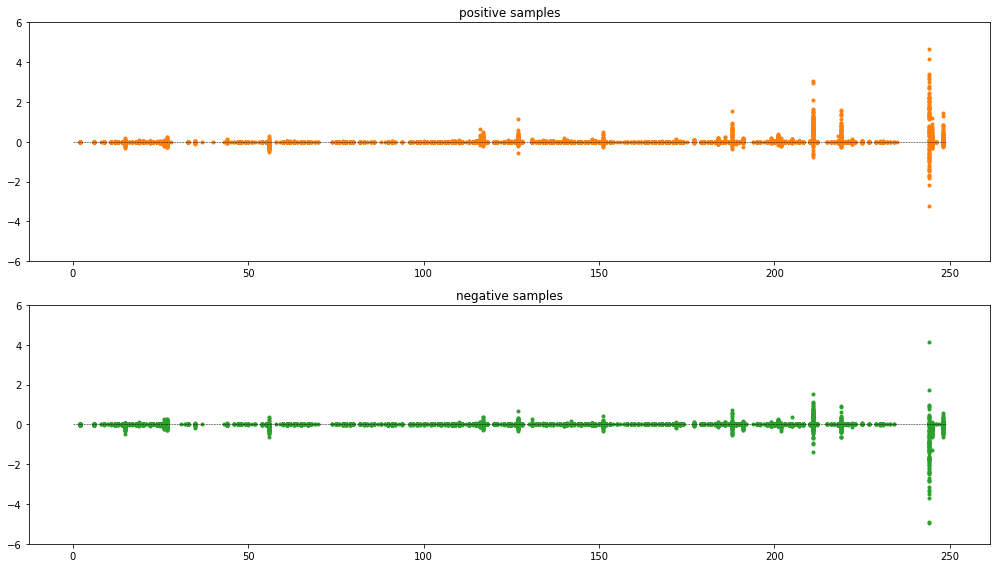

In [37]:
def zero_to_nan(row, p=75):
    out = np.array(row)
    _idx = np.where(np.abs(row) < np.percentile(np.abs(row), p))[0]
    out[_idx] = float('nan')
    return out


xaxis = np.arange(avg_omega.shape[1])

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

Single attention:

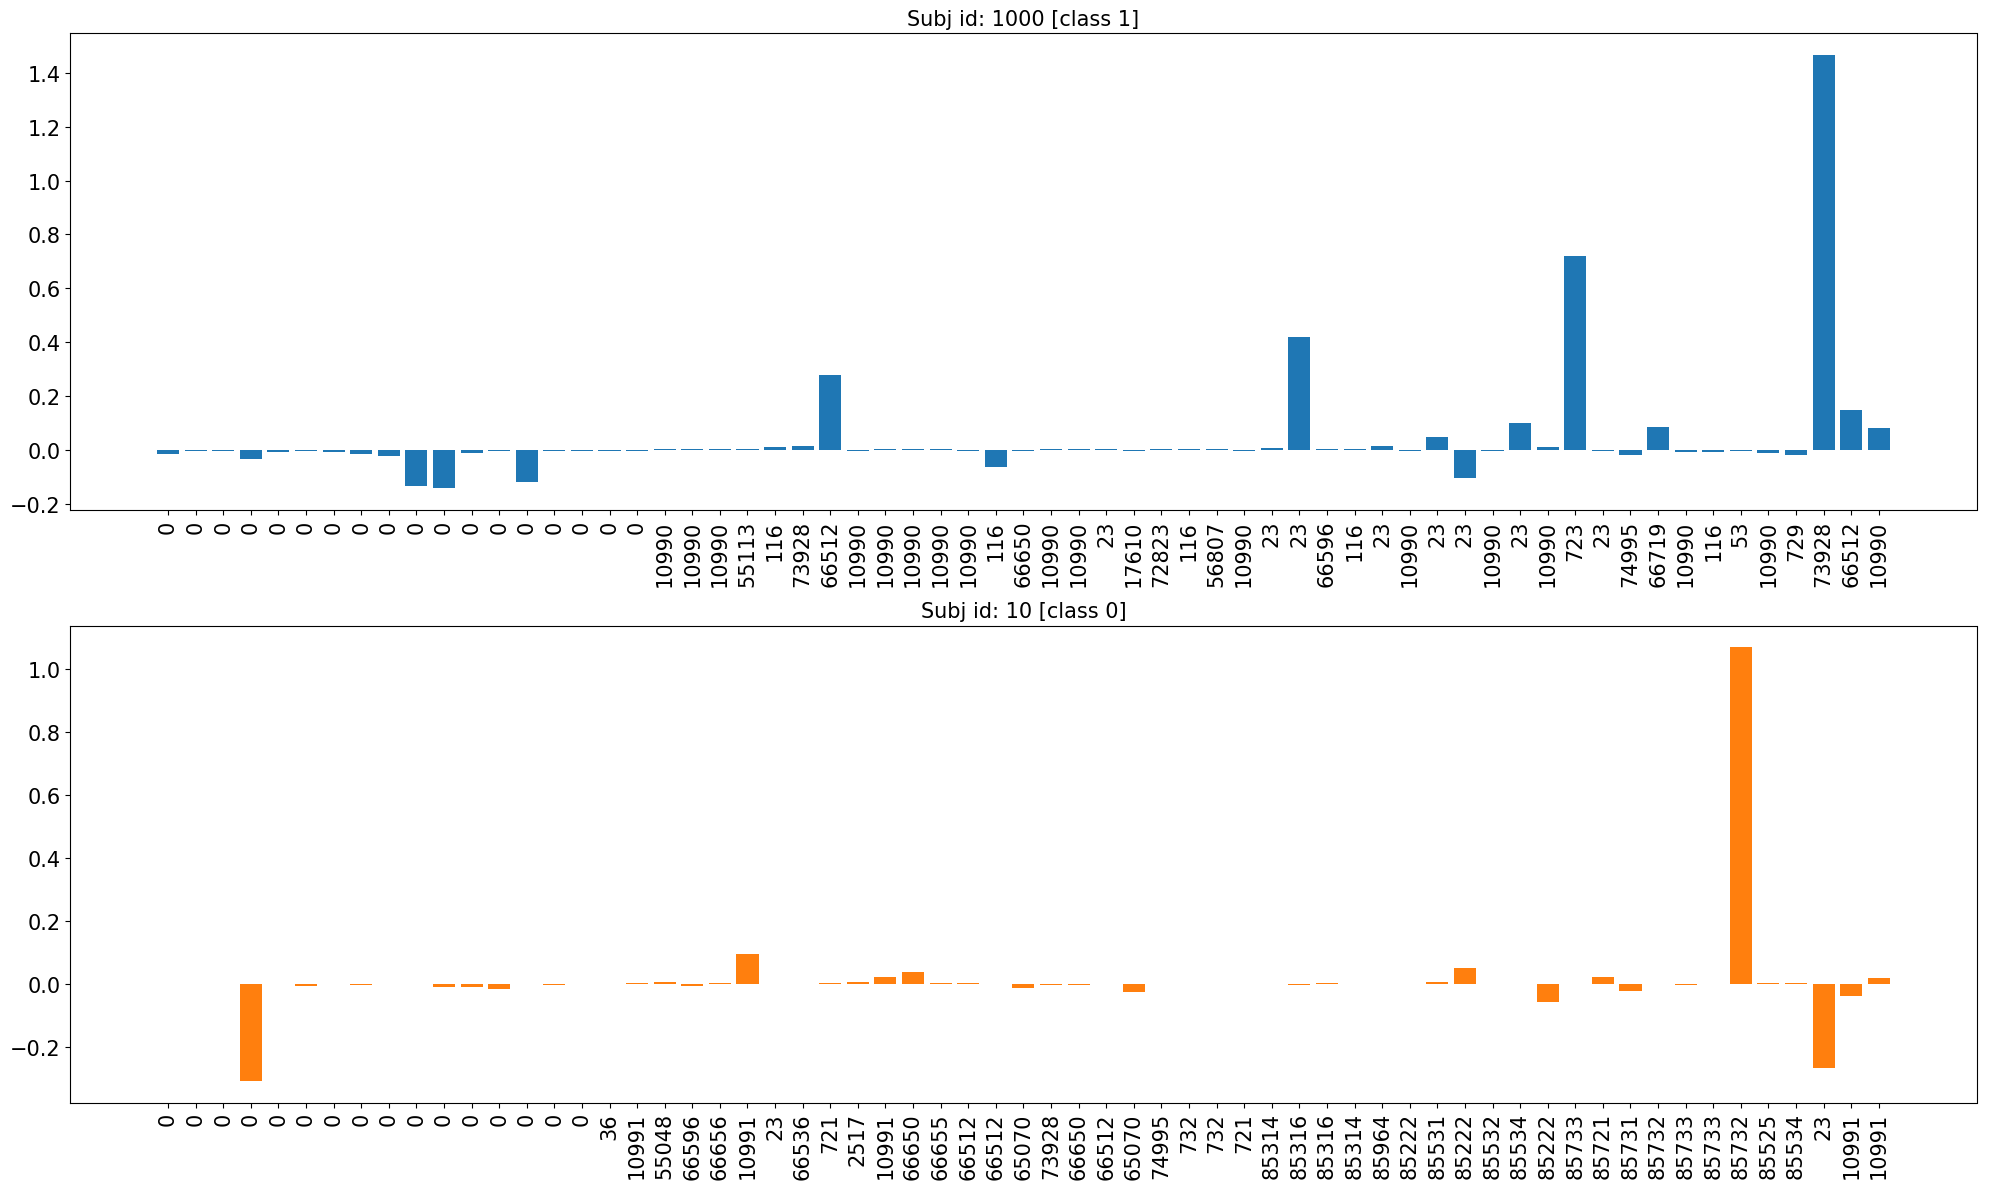

In [46]:
def attention_viz(i, color='C0'):
    # Load the mbs sequence from the dataset
    tokenized_seq = D[0][0][i]
    mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
    
    # Retrieve the corresponding attention vector
    attention = c[i].squeeze()
    
    # Filter out small attentions
    _idx = np.where(np.abs(attention) >= np.percentile(np.abs(attention), 75))[0]
    axis = np.arange(len(_idx))
    
    plt.bar(axis, attention[_idx], color=color)
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.tight_layout();
    

plt.figure(dpi=100, figsize=(20, 12))

plt.subplot(211)
attention_viz(1000, color='C0')

plt.subplot(212)
attention_viz(10, color='C1')

## Which MBS items get more attention?

In [39]:
from tqdm import tqdm, trange

def get_MBS_attention():
    # Save absolute value of attention level for each MBS item
    attention_dict = {}
    for i in trange(D[0][0].shape[0]):
        # Load the mbs sequence from the dataset
        tokenized_seq = D[0][0][i]
        mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
        
        # Retrieve the corresponding attention vector
        attention = np.abs(c[i].squeeze())
        
        # Keep nonzero only
        nz = np.where(mbs_seq != '0')[0]
        mbs_seq, attention = mbs_seq[nz], attention[nz]
        
        # Keep only the TOP 5%
        top_idx = np.where(attention >= np.percentile(attention, 75))[0]
        mbs_seq, attention = mbs_seq[top_idx], attention[top_idx]
    
        # Update the dict
        for item, att in zip(mbs_seq, attention):
            if item in attention_dict:
                attention_dict[item].append(att)
            else:
                attention_dict[item] = [att]
    
    return attention_dict

attention = get_MBS_attention()

100%|██████████| 4698/4698 [00:03<00:00, 1551.83it/s]


In [41]:
avg_attention = {k: np.sum(attention[k]) for k in attention.keys()}
dfa = pd.DataFrame(data=avg_attention.values(), index=avg_attention.keys(), columns=['Attention_overall'])
dfa['Mapped_Item_Desc'] = [item_map.loc[i, 'Mapped_Item_Desc'] for i in map(int, dfa.index)]
dfa['CATEGORY_DESC'] = [item_map.loc[i, 'CATEGORY_DESC'] for i in map(int, dfa.index)]

In [42]:
dfa.nlargest(25, columns='Attention_overall')

,Attention_overall,Mapped_Item_Desc,CATEGORY_DESC
23,2185.781006,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
10990,1744.855713,A medical service to which an item in this tab...,MISCELLANEOUS SERVICES
10991,1414.037598,A medical service to which an item in this tab...,MISCELLANEOUS SERVICES
73928,674.732849,Initiation of a patient episode by collection ...,PATHOLOGY SERVICES
66512,600.379150,5 or more tests described in item 66500,PATHOLOGY SERVICES
74995,531.626587,A payment when the episode is bulk billed and ...,PATHOLOGY SERVICES
36,380.631226,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
66551,298.247345,Quantitation of glycated haemoglobin performed...,PATHOLOGY SERVICES
65070,273.536072,"Erythrocyte count, haematocrit, haemoglobin, c...",PATHOLOGY SERVICES
66560,256.208832,Microalbumin - quantitation in urine,PATHOLOGY SERVICES


# Embedding viz

In [18]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [19]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

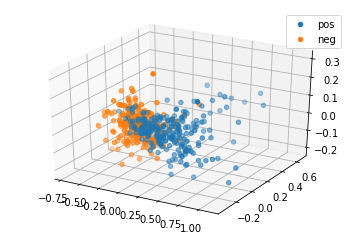

In [20]:
%matplotlib inline
MAX = 250

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();